# Content based recommendation system

The goal of this project was to develop a book recommendation system. Three content-based recommendation systems were created and benchmarked against each other. These systems were implemented using TF-IDF, word2vec, and Sentence-BERT, matching users to books based on their reading history.

## Scope

The scope of the study was restricted to the [Good Book](https://github.com/zygmuntz/goodbooks-10k) dataset. This dataset contains six million ratings for the ten thousand most popular books (those with the most ratings as of 2017). There are also individual book ratings by users, books marked to read by the users, book metadata (author, year, etc.) and tags/shelves/genres.

## Set-up

### Dependencies

In [1]:
import inspect
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random

from gensim.models import Word2Vec, KeyedVectors
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import word_tokenize

import sys
sys.path.insert(0, "C:\\Users\\billy\\OneDrive\\Documents\\Python Scripts\\1. Portfolio\\book-content-based-recommender\\book-content-based-recommender")
import custom_funcs as cf

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\billy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\billy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\billy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Import data

Dataset source: https://github.com/zygmuntz/goodbooks-10k

In [2]:
books = pd.read_csv('../data/raw/books.csv')
to_read = pd.read_csv('../data/raw/to_read.csv')
ratings = pd.read_csv('../data/raw/ratings.csv')
book_tags = pd.read_csv('../data/raw/book_tags.csv')
tags = pd.read_csv('../data/raw/tags.csv')

## Data exploration

Note on book identifiers:

* Each book may have many editions.  **_goodreads_book_id_** and **_best_book_id_** generally point to the most popular edition of a given book, while goodreads  **_work_id_** refers to the book in the abstract sense. 

* Note that _book_id_ in **ratings.csv** and **to_read.csv** maps to **_work_id_**, not to **_goodreads_book_id_**, meaning that ratings for different editions are aggregated.

### books

In [3]:
# Dimensions
print(f"Number of records: {books.shape[0]}")
print(f"Number of columns: {books.shape[1]}")
books.head(2)

Number of records: 10000
Number of columns: 23


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


In [4]:
# Data types
display(books.dtypes.value_counts())
print("\n")
books.dtypes

int64      13
object      7
float64     3
Name: count, dtype: int64

book_id                        int64
goodreads_book_id              int64
best_book_id                   int64
work_id                        int64
books_count                    int64
isbn                          object
isbn13                       float64
authors                       object
original_publication_year    float64
original_title                object
title                         object
language_code                 object
average_rating               float64
ratings_count                  int64
work_ratings_count             int64
work_text_reviews_count        int64
ratings_1                      int64
ratings_2                      int64
ratings_3                      int64
ratings_4                      int64
ratings_5                      int64
image_url                     object
small_image_url               object
dtype: object

In [5]:
# Languages
display(books.language_code.value_counts())

language_code
eng      6341
en-US    2070
en-GB     257
ara        64
en-CA      58
fre        25
ind        21
spa        20
ger        13
per         7
jpn         7
por         6
pol         6
en          4
nor         3
dan         3
fil         2
ita         2
vie         1
tur         1
nl          1
swe         1
rum         1
mul         1
rus         1
Name: count, dtype: int64

In [6]:
# Get a list of book_ids for non-english books
non_english_book_ids = books.loc[books.language_code.isin(['eng', 'en-US', 'en-GB', 'en-CA'])==False, "book_id"].tolist()

# Filter so only English books remain
books = books.loc[books.language_code.isin(['eng', 'en-US', 'en-GB', 'en-CA'])]
books = books.reset_index(drop=True)
print(f"Number of records: {books.shape[0]}")

Number of records: 8726


In [7]:
# Missing values
books.isnull().sum()[(books.isnull().sum() > 1)]

isbn                         584
isbn13                       508
original_publication_year     15
original_title               494
dtype: int64

In [8]:
# Duplicate values
books[books.duplicated()]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url


In [9]:
# Number of unique value per columns
books.nunique()

book_id                      8726
goodreads_book_id            8726
best_book_id                 8726
work_id                      8726
books_count                   563
isbn                         8142
isbn13                       7995
authors                      4086
original_publication_year     277
original_title               8110
title                        8703
language_code                   4
average_rating                182
ratings_count                8014
work_ratings_count           8024
work_text_reviews_count      4430
ratings_1                    2549
ratings_2                    3959
ratings_3                    6402
ratings_4                    7065
ratings_5                    7326
image_url                    5992
small_image_url              5992
dtype: int64

In [10]:
books[['average_rating', 'work_ratings_count']].describe()

,average_rating,work_ratings_count
count,8726.000000,8.726000e+03
mean,4.003309,6.430620e+04
std,0.252592,1.778604e+05
min,2.470000,6.323000e+03
25%,3.850000,1.610650e+04
50%,4.020000,2.509650e+04
75%,4.180000,4.952025e+04
max,4.820000,4.942365e+06


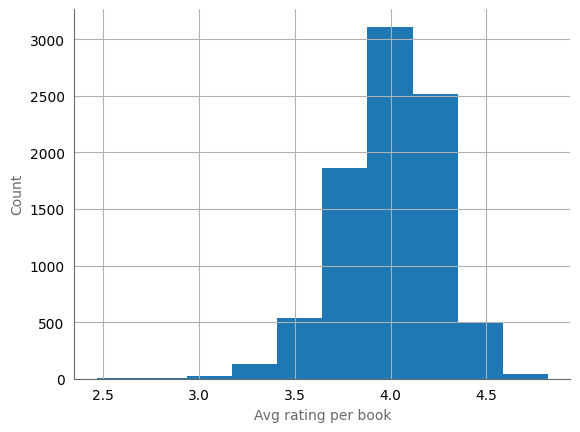

In [11]:
# Average rating per book
fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(True)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_xlabel('Avg rating per book', fontsize=10, color='dimgray')
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.hist(books['average_rating']);

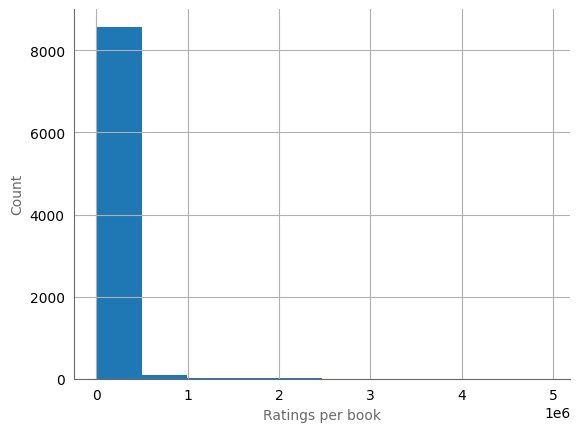

In [12]:
# Average rating per book
fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(True)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_xlabel('Ratings per book', fontsize=10, color='dimgray')
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.hist(books['work_ratings_count']);

### ratings

In [13]:
# Dimensions
print(f"Number of records: {ratings.shape[0]}")
print(f"Number of columns: {ratings.shape[1]}")
ratings.head(2)

Number of records: 5976479
Number of columns: 3


,user_id,book_id,rating
0,1,258,5
1,2,4081,4


In [14]:
# Filter out non english books
ratings = ratings.loc[ratings["book_id"].isin(non_english_book_ids)==False]
ratings = ratings.reset_index(drop=True)
print(f"Number of records: {ratings.shape[0]}")

Number of records: 5577975


In [15]:
# Data types
display(ratings.dtypes.value_counts())
print("\n")
ratings.dtypes

int64    3
Name: count, dtype: int64

user_id    int64
book_id    int64
rating     int64
dtype: object

In [16]:
# Missing values
ratings.isnull().sum()[(ratings.isnull().sum() > 1)]

Series([], dtype: int64)

In [17]:
# Duplicate values
ratings[ratings.duplicated()]

,user_id,book_id,rating


In [18]:
# Number of ratings per user
ratings_per_user = ratings.groupby("user_id")["rating"].count().sort_values()
ratings_per_user.describe()

count    53424.000000
mean       104.409535
std         25.367577
min          1.000000
25%         90.000000
50%        104.000000
75%        120.000000
max        195.000000
Name: rating, dtype: float64

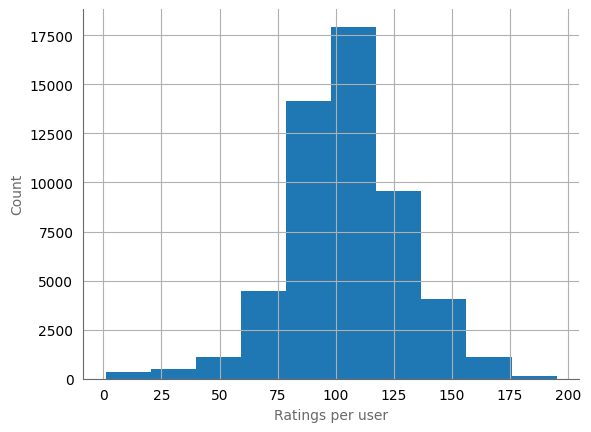

In [19]:
# Number of ratings per user
fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(True)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_xlabel('Ratings per user', fontsize=10, color='dimgray')
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.hist(ratings_per_user);

### to read

In [20]:
# Dimensions
print(f"Number of records: {to_read.shape[0]}")
print(f"Number of columns: {to_read.shape[1]}")
to_read.head(2)

Number of records: 912705
Number of columns: 2


,user_id,book_id
0,9,8
1,15,398


In [21]:
# Filter out non english books
to_read = to_read.loc[to_read["book_id"].isin(non_english_book_ids)==False]
to_read = to_read.reset_index(drop=True)
print(f"Number of records: {to_read.shape[0]}")

Number of records: 861285


In [22]:
# Data types
display(to_read.dtypes.value_counts())
print("\n")
to_read.dtypes

int64    2
Name: count, dtype: int64

user_id    int64
book_id    int64
dtype: object

In [23]:
# Missing values
to_read.isnull().sum()[(to_read.isnull().sum() > 1)]

Series([], dtype: int64)

In [24]:
# Duplicate values
to_read[to_read.duplicated()]

,user_id,book_id


In [25]:
# To read per user
toread_per_user = to_read.groupby("user_id")["book_id"].count().sort_values()
toread_per_user.describe()

count    48646.000000
mean        17.705156
std         15.275207
min          1.000000
25%          6.000000
50%         13.000000
75%         26.000000
max        107.000000
Name: book_id, dtype: float64

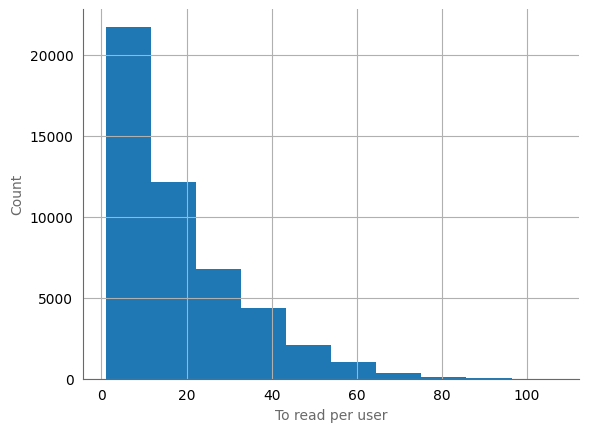

In [26]:
# Number of books to read per user
fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(True)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_xlabel('To read per user', fontsize=10, color='dimgray')
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.hist(toread_per_user);

### book tags

In [27]:
# Dimensions
print(f"Number of records: {book_tags.shape[0]}")
print(f"Number of columns: {book_tags.shape[1]}")
book_tags.head(2)

Number of records: 999912
Number of columns: 3


,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174


In [28]:
# Data types
display(book_tags.dtypes.value_counts())
print("\n")
book_tags.dtypes

int64    3
Name: count, dtype: int64

goodreads_book_id    int64
tag_id               int64
count                int64
dtype: object

In [29]:
# Missing values
book_tags.isnull().sum()[(book_tags.isnull().sum() > 1)]

Series([], dtype: int64)

In [30]:
# Duplicate values
book_tags[book_tags.duplicated()]

,goodreads_book_id,tag_id,count
159371,22369,25148,4
265128,52629,10094,1
265140,52629,2928,1
265155,52629,13272,1
265187,52629,13322,1
308771,77449,25148,7


In [31]:
# Remove duplicates
book_tags = book_tags.loc[book_tags.duplicated() == False, :]

In [32]:
# Number of tags per book
tags_per_book = book_tags.groupby("goodreads_book_id")["tag_id"].count().sort_values()
tags_per_book.describe()

count    10000.000000
mean        99.990600
std          0.585957
min         56.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: tag_id, dtype: float64

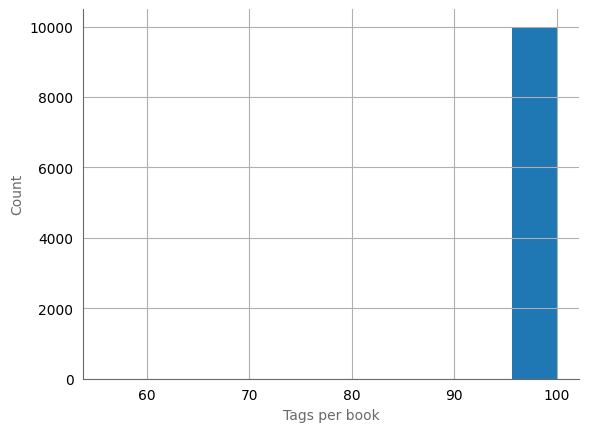

In [33]:
# Number of tags per book
fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(True)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_xlabel('Tags per book', fontsize=10, color='dimgray')
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.hist(tags_per_book);

### tags

In [34]:
# Dimensions
print(f"Number of records: {tags.shape[0]}")
print(f"Number of columns: {tags.shape[1]}")
tags.head(2)

Number of records: 34252
Number of columns: 2


,tag_id,tag_name
0,0,-
1,1,--1-


In [35]:
# Data types
display(tags.dtypes.value_counts())
print("\n")
tags.dtypes

int64     1
object    1
Name: count, dtype: int64

tag_id       int64
tag_name    object
dtype: object

In [36]:
# Missing values
tags.isnull().sum()[(tags.isnull().sum() > 1)]

Series([], dtype: int64)

In [37]:
# Duplicate values
tags[tags.duplicated()]

,tag_id,tag_name


## Pre-processing

### Decodes

In [38]:
# Add tag names to book tags df
print(f"Shape before join: {book_tags.shape}")
book_tags = book_tags.merge(tags, on="tag_id", how="left", suffixes=('', '_remove'))
book_tags = book_tags.drop([col for col in book_tags.columns if 'remove' in col], axis=1)
print(f"Shape after join: {book_tags.shape}")
print(f"\nMissing values :\n{book_tags.isna().sum()}")
display(book_tags.head())

Shape before join: (999906, 3)
Shape after join: (999906, 4)

Missing values :
goodreads_book_id    0
tag_id               0
count                0
tag_name             0
dtype: int64


,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,1,11305,37174,fantasy
2,1,11557,34173,favorites
3,1,8717,12986,currently-reading
4,1,33114,12716,young-adult


In [39]:
# Aggregate tag names by goodreads_book_id
tag_name_lookup = book_tags.groupby("goodreads_book_id")["tag_name"].apply(list).rename("book_tags")
tag_name_lookup = tag_name_lookup.apply(lambda x: " ".join(list(x)))
tag_name_lookup = tag_name_lookup.reset_index()
print(f"Tag name lookup shape: {tag_name_lookup.shape}")
print(f"Missing book tags :\n{tag_name_lookup['book_tags'].isna().sum()}")
display(tag_name_lookup.head())

Tag name lookup shape: (10000, 2)
Missing book tags :
0


,goodreads_book_id,book_tags
0,1,to-read fantasy favorites currently-reading yo...
1,2,to-read currently-reading fantasy favorites ch...
2,3,to-read favorites fantasy currently-reading yo...
3,5,favorites fantasy currently-reading young-adul...
4,6,fantasy young-adult fiction harry-potter owned...


In [40]:
# Add aggregated tag names to books df
print(f"Shape before join: {books.shape}")
books = books.merge(tag_name_lookup, on="goodreads_book_id", how="left", suffixes=('', '_remove'))
books = books.drop([col for col in books.columns if 'remove' in col], axis=1)
print(f"Shape after join: {books.shape}")
print(f"Missing book tags :\n{books['book_tags'].isna().sum()}")
display(books[["goodreads_book_id", "book_tags"]].head())

Shape before join: (8726, 23)
Shape after join: (8726, 24)
Missing book tags :
0


,goodreads_book_id,book_tags
0,2767052,favorites currently-reading young-adult fictio...
1,3,to-read favorites fantasy currently-reading yo...
2,41865,young-adult fantasy favorites vampires ya fict...
3,2657,classics favorites to-read classic historical-...
4,4671,classics favorites fiction classic books-i-own...


In [41]:
# Add book title and tag names to ratings
print(f"Shape before join: {ratings.shape}")
ratings = ratings.merge(books[["book_id", "title", "authors", "book_tags"]], left_on="book_id", right_on="book_id", how="left", suffixes=("", "_remove"))
ratings = ratings.drop([col for col in ratings.columns if "remove" in col], axis=1)

print(f"Shape after join: {ratings.shape}")
print(f"Missing values :\n{ratings.isna().sum()}")
display(ratings.head())

Shape before join: (5577975, 3)
Shape after join: (5577975, 6)
Missing values :
user_id      0
book_id      0
rating       0
title        0
authors      0
book_tags    0
dtype: int64


,user_id,book_id,rating,title,authors,book_tags
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...,"Carlos Ruiz Zafón, Lucia Graves",to-read currently-reading favorites fiction hi...
1,2,4081,4,I am Charlotte Simmons,Tom Wolfe,to-read fiction currently-reading favorites ow...
2,2,260,5,How to Win Friends and Influence People,Dale Carnegie,non-fiction to-read self-improvement nonfictio...
3,2,9296,5,The Drama of the Gifted Child: The Search for ...,"Alice Miller, Ruth Ward",to-read psychology non-fiction nonfiction self...
4,2,2318,3,The Millionaire Next Door: The Surprising Secr...,"Thomas J. Stanley, William D. Danko",to-read currently-reading non-fiction finance ...


In [42]:
# Add book title and tag names to to_read
print(f"Shape before join: {to_read.shape}")
to_read = to_read.merge(books[["book_id", "title", "authors", "book_tags"]], left_on="book_id", right_on="book_id", how="left", suffixes=("", "_remove"))
to_read = to_read.drop([col for col in to_read.columns if "remove" in col], axis=1)
print(f"Shape after join: {to_read.shape}")
print(f"Missing values :\n{to_read.isna().sum()}")
display(to_read.head())

Shape before join: (861285, 2)
Shape after join: (861285, 5)
Missing values :
user_id      0
book_id      0
title        0
authors      0
book_tags    0
dtype: int64


,user_id,book_id,title,authors,book_tags
0,9,8,The Catcher in the Rye,J.D. Salinger,classics favorites fiction to-read classic you...
1,15,398,Fast Food Nation: The Dark Side of the All-Ame...,Eric Schlosser,to-read non-fiction nonfiction currently-readi...
2,15,275,An Abundance of Katherines,John Green,currently-reading young-adult to-read favorite...
3,37,7173,Musashi,"Eiji Yoshikawa, Charles Terry, Edwin O. Reisch...",to-read currently-reading fiction historical-f...
4,34,380,Norwegian Wood,"Haruki Murakami, Jay Rubin",to-read currently-reading favorites fiction ja...


### Book profiles

**Title-author-tags**

The feature representations of each book are created using the title, author and tags.

In [43]:
# Create book id-tag lookup
book_profile = books.groupby("book_id")[["title", "authors", "book_tags"]].first()
book_profile["book_profile"] = book_profile["title"] + " " + book_profile["authors"] # + " " + book_profile["book_tags"].fillna(" ")
book_profile["book_profile"] = book_profile["book_profile"].str.lower()
print(f"Shape: {book_profile.shape}")
print(f"Missing values :\n{book_profile.isna().sum()}")
display(book_profile.head())

Shape: (8726, 4)
Missing values :
title           0
authors         0
book_tags       0
book_profile    0
dtype: int64


,title,authors,book_tags,book_profile
book_id,,,,
1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,favorites currently-reading young-adult fictio...,"the hunger games (the hunger games, #1) suzann..."
2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",to-read favorites fantasy currently-reading yo...,harry potter and the sorcerer's stone (harry p...
3,"Twilight (Twilight, #1)",Stephenie Meyer,young-adult fantasy favorites vampires ya fict...,"twilight (twilight, #1) stephenie meyer"
4,To Kill a Mockingbird,Harper Lee,classics favorites to-read classic historical-...,to kill a mockingbird harper lee
5,The Great Gatsby,F. Scott Fitzgerald,classics favorites fiction classic books-i-own...,the great gatsby f. scott fitzgerald


In [44]:
# Add book profile to books df
print(f"Shape before join: {books.shape}")
books = books.merge(book_profile, left_on="book_id", right_on="book_id", how="left", suffixes=("", "_remove"))
books = books.drop([col for col in books.columns if "remove" in col], axis=1)
print(f"Shape after join: {books.shape}")
print(f"Missing values :\n{books.isna().sum()}")
display(books.head(2))

Shape before join: (8726, 24)
Shape after join: (8726, 25)
Missing values :
book_id                        0
goodreads_book_id              0
best_book_id                   0
work_id                        0
books_count                    0
isbn                         584
isbn13                       508
authors                        0
original_publication_year     15
original_title               494
title                          0
language_code                  0
average_rating                 0
ratings_count                  0
work_ratings_count             0
work_text_reviews_count        0
ratings_1                      0
ratings_2                      0
ratings_3                      0
ratings_4                      0
ratings_5                      0
image_url                      0
small_image_url                0
book_tags                      0
book_profile                   0
dtype: int64


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,book_tags,book_profile
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,favorites currently-reading young-adult fictio...,"the hunger games (the hunger games, #1) suzann..."
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,to-read favorites fantasy currently-reading yo...,harry potter and the sorcerer's stone (harry p...


**Popularity ranking**

An overall popularity rank is calculated for each book using the ratings dataset and the following steps:

1. Sort & rank books by the number of ratings

2. Sort & rank books by average rating

3. Combine rankings with a weight of 0.5 for each (these weights are hyperparameters, adjust as needed)

In [45]:
# Sort & rank books by the number of ratings
books = books.sort_values(by='work_ratings_count', ascending=False)
books['popularity_rank'] = range(1, len(books) + 1)

# Sort & rank books by average rating
books = books.sort_values(by='average_rating', ascending=False)
books['quality_rank'] = range(1, len(books) + 1)

# Combine rankings (adjust weights as needed)
books["combined_rank"] = 0.75*books["popularity_rank"] + 0.25*books["quality_rank"]
books = books.sort_index()
books.head(2)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_3,ratings_4,ratings_5,image_url,small_image_url,book_tags,book_profile,popularity_rank,quality_rank,combined_rank
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,favorites currently-reading young-adult fictio...,"the hunger games (the hunger games, #1) suzann...",1,654,164.25
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,to-read favorites fantasy currently-reading yo...,harry potter and the sorcerer's stone (harry p...,2,238,61.00


### User profiles
* The ratings dataset will be split into a training/test set.

* Recommendations will be made for each user in the test data using user profiles constructed from the training data.

* The actual books rated by each user in the test data will be considered the ground truth during evaluation.

In [46]:
ratings["book_profile"] = ratings["title"] + " " + ratings["authors"] # + " " + ratings["book_tags"].fillna(" ")

In [47]:
from sklearn.model_selection import train_test_split
train_ratings, test_ratings = train_test_split(ratings, test_size=0.25, random_state=0)
train_ratings = train_ratings.reset_index(drop=True)
test_ratings = test_ratings.reset_index(drop=True)

print(f"Training set shape: {train_ratings.shape}")
# display(train_ratings.head())
print(f"Test set shape: {test_ratings.shape}")
display(test_ratings.head())

Training set shape: (4183481, 7)
Test set shape: (1394494, 7)


,user_id,book_id,rating,title,authors,book_tags,book_profile
0,7829,2125,4,"The Book of Three (The Chronicles of Prydain, #1)",Lloyd Alexander,to-read fantasy young-adult fiction favorites ...,"The Book of Three (The Chronicles of Prydain, ..."
1,31465,2817,5,Chapterhouse: Dune (Dune Chronicles #6),Frank Herbert,science-fiction sci-fi fiction currently-readi...,Chapterhouse: Dune (Dune Chronicles #6) Frank ...
2,41723,947,4,"Angelfall (Penryn & the End of Days, #1)",Susan Ee,to-read favorites fantasy young-adult currentl...,"Angelfall (Penryn & the End of Days, #1) Susan Ee"
3,41595,415,1,"Evermore (The Immortals, #1)",Alyson Noel,to-read young-adult fantasy currently-reading ...,"Evermore (The Immortals, #1) Alyson Noel"
4,51601,70,5,"Ender's Game (Ender's Saga, #1)",Orson Scott Card,to-read science-fiction favorites sci-fi curre...,"Ender's Game (Ender's Saga, #1) Orson Scott Card"


## Baseline models

### Random model

Basic principle:

* A user is randomly recommended n books they haven't read.

#### Algorithm
Key steps: 

1. Exclude books already rated or marked to read by the user from recommendations

2. Randomly select the top n books for the final sample.

In [48]:
# print(inspect.getsource(cf.random_rec))

def get_random_recs(user_id, all_user_ratings, all_user_toread, all_books, n_sample):
    """
    Function to get content-based book recommendations for a given user profile

    Parameters:
    - user_id: User id
    - all_user_ratings: DataFrame containing ratings history for all users.
    - all_user_toread: DataFrame containing to read list for all users.
    - all_books: DataFrame containing metadata for all books.
    - n_sample: Number of recommendations to generate.

    Returns: List of book recommended ids 
    """
    
    # User history
    rating_history = all_user_ratings.loc[all_user_ratings["user_id"] == user_id, "book_id"].tolist()
    toread_history = all_user_toread.loc[all_user_toread["user_id"] == user_id, "book_id"].tolist()
    user_history = set(rating_history).union(set(toread_history))
    
    # Exclude books already rated by the user and in the to read list from recommendations
    user_shortlist = all_books.iloc[np.isin(all_books["book_id"], user_history) == False]

    # Randomly sample top k books
    user_recs = user_shortlist.sample(n=n_sample, random_state=0)

    return user_recs["book_id"].tolist()

In [49]:
# Example
USER_ID = 10
N_SAMPLE = 25
books.loc[books["book_id"].isin(get_random_recs(USER_ID,
                                                train_ratings,
                                                to_read,
                                                books,
                                                N_SAMPLE)
                               ), "title"].tolist()

['A Breath of Snow and Ashes (Outlander, #6)',
 'The Nest',
 'Queen of Babble (Queen of Babble, #1)',
 'Tithe (Modern Faerie Tales, #1)',
 'The Search',
 'Theodore Rex',
 'The Boys from Brazil',
 'Total Control',
 'The Lion (John Corey, #5)',
 'Testimony',
 'The Walking Dead, Vol. 06: This Sorrowful Life',
 'Conspiracy in Death (In Death, #8)',
 'The Complete Poems',
 'Magic Breaks (Kate Daniels, #7)',
 'The Third Twin',
 'The Enchantress of Florence',
 'The Grand Sophy',
 'All Our Yesterdays',
 'Elephants Can Remember (Hercule Poirot, #37)',
 'Clean Sweep (Innkeeper Chronicles, #1)',
 'Broken Silence (Silence, #2)',
 "Ain't She Sweet",
 'Shoeless Joe',
 'Si-cology 1: Tales and Wisdom from Duck Dynasty’s Favorite Uncle',
 'Life Before Legend: Stories of the Criminal and the Prodigy (Legend, #0.5)']

#### Evaluation

Key steps:

1. Split the training set into k folds. Use k-1 folds as the training set. Use the remaining data as a validation set.

2. Apply recommendation system to each user in the validation set. Output a dictionary containing predicted items for each user.

3. Create ground truth for each user in the validation set. Output a dictionary containing actual relevant items for each user.

4. Evaluate performance on a per user basis. Output a dictionary containing the relevant metric score for each user.

5. Calculate average performance across users.

6. Repeat steps 2 - 5 k times.

In [50]:
# N_SPLITS = 3  # Number of splits for kfold cross validation
# N_SAMPLE = 25  # Number of recommendations
# TOP_K = 25
# avg_precision_at_k, avg_recall_at_k, avg_map_at_k = cf.calculate_baseline_cv_score(get_random_recs,
#                                                                                    train_ratings,
#                                                                                    to_read,
#                                                                                    books,
#                                                                                    N_SAMPLE,
#                                                                                    N_SPLITS,
#                                                                                    TOP_K
#                                                                                    )

# print(f"precision@k: {avg_precision_at_k}")
# print(f"recall@k: {avg_recall_at_k}")
# print(f"mean average precision@k: {avg_map_at_k}")

### Popularity based model

Basic principle:

* A user is recommended the n most popular books they haven't seen.

#### Algorithm

Key steps: 

1. Exclude books already rated or marked to read by the user from recommendations

2. Sort the books in descending order by the number of ratings

3. Sort the books in descending order by quality (i.e. average rating)

4. Combine the rankings using a weighted average.

5. Select the top n books for the final sample

In [51]:
# print(inspect.getsource(cf.popularity_rec))

def get_popularity_recs(user_id, all_user_ratings, all_user_toread, all_books, n_sample):
    """
    Function to get content-based book recommendations for a given user profile

    Parameters:
    - user_id: User id
    - all_user_ratings: DataFrame containing ratings history for all users.
    - all_user_toread: DataFrame containing to read list for all users.
    - all_books: DataFrame containing metadata for all books.
    - n_sample: Number of recommendations to generate.

    Returns: List of book recommended ids 
    """

    # User history
    rating_history = all_user_ratings.loc[all_user_ratings["user_id"] == user_id, "book_id"].tolist()
    toread_history = all_user_toread.loc[all_user_toread["user_id"] == user_id, "book_id"].tolist()
    user_history = set(rating_history).union(set(toread_history))
    
    # Exclude books already rated by the user and in the to read list from recommendations
    user_shortlist = all_books.iloc[np.isin(all_books["book_id"], user_history) == False]

    # Return top k books
    user_shortlist = user_shortlist.sort_values(by='combined_rank', ascending=True)
    user_recs = user_shortlist[0:n_sample]

    return user_recs["book_id"].tolist()

In [52]:
# Example
USER_ID = 10
N_SAMPLE = 25
books.loc[books["book_id"].isin(get_popularity_recs(USER_ID,
                                                    train_ratings,
                                                    to_read,
                                                    books,
                                                    N_SAMPLE)
                                ), "title"].tolist()

['The Hunger Games (The Hunger Games, #1)',
 "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
 'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)',
 'The Fellowship of the Ring (The Lord of the Rings, #1)',
 'Harry Potter and the Order of the Phoenix (Harry Potter, #5)',
 'Harry Potter and the Chamber of Secrets (Harry Potter, #2)',
 'Harry Potter and the Goblet of Fire (Harry Potter, #4)',
 'Harry Potter and the Deathly Hallows (Harry Potter, #7)',
 'Harry Potter and the Half-Blood Prince (Harry Potter, #6)',
 'The Help',
 'A Game of Thrones (A Song of Ice and Fire, #1)',
 'The Book Thief',
 'A Thousand Splendid Suns',
 'The Giving Tree',
 'A Clash of Kings  (A Song of Ice and Fire, #2)',
 'A Storm of Swords (A Song of Ice and Fire, #3)',
 'The Martian',
 'Unbroken: A World War II Story of Survival, Resilience, and Redemption',
 'The Two Towers (The Lord of the Rings, #2)',
 'The Battle of the Labyrinth (Percy Jackson and the Olympians, #4)',
 'The Return of the K

#### Evaluation
Key steps:

1. Split the training set into k folds. Use k-1 folds as the training set. Use the remaining data as a validation set.

2. Apply recommendation system to each user in the validation set. Output a dictionary containing predicted items for each user.

3. Create ground truth for each user in the validation set. Output a dictionary containing actual relevant items for each user.

4. Evaluate performance on a per user basis. Output a dictionary containing the relevant metric score for each user.

5. Calculate average performance across users.

6. Repeat steps 2 - 5 k times.

In [53]:
# N_SPLITS = 3  # Number of splits for kfold cross validation
# N_SAMPLE = 25  # Number of recommendations
# TOP_K = 25
# avg_precision_at_k, avg_recall_at_k, avg_map_at_k = cf.calculate_baseline_cv_score(get_popularity_recs,
#                                                                                    train_ratings,
#                                                                                    to_read,
#                                                                                    books,
#                                                                                    N_SAMPLE,
#                                                                                    N_SPLITS,
#                                                                                    TOP_K)

# print(f"precision@k: {avg_precision_at_k}")
# print(f"recall@k: {avg_recall_at_k}")
# print(f"mean average precision@k: {avg_map_at_k}")

## Content based filtering recommendation system

### Algorithm
Key steps: 

1. Filter the similarity matrix so only the specified user remains.

2. Sort the books in descending order by similarity

3. Exclude books already rated or marked to read by the user from recommendations

4. Select the top n books for the final sample

In [54]:
def get_content_based_recs(user_id, similarity_matrix, user_matrix_ids, all_user_ratings, all_user_toread, all_books, n_sample):
    """
    Function to get content-based book recommendations for a given user profile

    Parameters:
    - user_id: User id
    - similarity_matrix: Numpy array of similarity scores. Each row corresponds to a user and each column corresponds to a book.
    - user_matrix_ids: Numpy array of user ids corresponding to rows of the similarity matrix
    - all_user_ratings: DataFrame containing ratings history for all users.
    - all_user_toread: DataFrame containing to read list for all users.
    - all_books: DataFrame containing metadata for all books.
    - n_sample: Number of recommendations to generate.

    Returns: List of book recommended ids 
    """

    # Lookup user id position in similarity matrix
    user_idx = np.where(user_matrix_ids == user_id)[0][0]

    # Filter and sort similarity matrix
    book_user_similarities = list(enumerate(similarity_matrix[user_idx]))
    book_user_similarities = sorted(
        book_user_similarities, key=lambda x: x[1], reverse=True)

    # User history
    rating_history = all_user_ratings.loc[all_user_ratings["user_id"]
                                          == user_id, "book_id"].tolist()
    toread_history = all_user_toread.loc[all_user_toread["user_id"]
                                         == user_id, "book_id"].tolist()
    user_history = set(rating_history).union(set(toread_history))

    # Lookup book_id and filter out books in the user history
    user_recs = [all_books.loc[book_idx, "book_id"] for book_idx, score in book_user_similarities
                 if all_books.loc[book_idx, "book_id"] not in user_history]

    return user_recs[0:n_sample]

### Model 1 - tf.idf
Basic principle:

* Items are recommended to a given user based on their ratings and toread history and the similarity of this profile to unread books.

* The profile for each user and book is translated into feature space using tf.idf vectorisation. 

#### Feature extraction

* The TF-IDF matrix is precomputed for each book and user. This speeds up computation time.

* A vector feature representing book content is created using the book profile column.
  
* The tf.idf vectorizer is fit using the book profile column. This determines the vocab size and associated vector length when vectorising user profiles later. Any unseen terms in the user profile will not be incorporated into the vector. This is a limitation of the tf.idf approach.

In [55]:
# Stop words
custom_stop_words = []
a = nltk.corpus.stopwords.words('english')
b = list(string.punctuation) + custom_stop_words
stopwords = set(a).union(b)

# Lemmatizer
lemmatizer = WordNetLemmatizer()

##### Book profiles

* The TF-IDF matrix is precomputed for each book
  
* Each row corresponds to a book

In [56]:
# Create matrix of book vectors
books = books.sort_index()
tfidf_book_profiles = books['book_profile'].apply(lambda x: cf.preprocess_text(x, stopwords, lemmatizer))
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_book_matrix = tfidf_vectorizer.fit_transform(tfidf_book_profiles.to_numpy())
print(tfidf_book_matrix.shape)

# Create book_id lookup
tfidf_book_matrix_ids = books["book_id"].to_numpy()

(8726, 12146)


##### User profiles

* The TF-IDF matrix is precomputed for each book

* Each row corresponds to a user

In [57]:
# Create matrix of user vectors
all_user_profiles = train_ratings.groupby("user_id")["book_profile"].agg(lambda x: " ".join(x)).rename("user_profile")
tfidf_user_profiles = all_user_profiles.apply(lambda x: cf.preprocess_text(x, stopwords, lemmatizer))
tfidf_user_matrix = tfidf_vectorizer.transform(tfidf_user_profiles.to_numpy())
print(tfidf_user_matrix.shape)

# Create user_id lookup
tfidf_user_matrix_ids = tfidf_user_profiles.index.to_numpy()

(53424, 12146)


#### Similarity matrix

* To avoid redundent calculations, cosine similarities are calculated between all user profile vectors and all book profile vectors at once (rather than repeatedly within a function).
  
* Cosine similarity is a measure of similarity between two vectors that is widely used in text analysis. When working with TF-IDF vectors, it ranges from 0 to 1, with 1 indicating perfect similarity and 0 indicating no similarity (i.e. no shared terms)
  
* The similarity matrix contains a row for each user and each column corresponds to a book

In [58]:
tfidf_similarity_matrix = cosine_similarity(tfidf_user_matrix, tfidf_book_matrix)
tfidf_similarity_matrix.shape

(53424, 8726)

#### Algorithm

Key steps: 

1. Filter the similarity matrix so only the specified user remains.

2. Sort the books in descending order by similarity

3. Exclude books already rated or marked to read by the user from recommendations

4. Select the top n books for the final sample

In [59]:
# def get_tfidf_based_recs(user_id, similarity_matrix, user_matrix_ids, all_user_ratings, all_user_toread, all_books, n_sample):
#     """
#     Function to get content-based book recommendations for a given user profile

#     Parameters:
#     - user_id: User id
#     - similarity_matrix: Numpy array of similarity scores. Each row corresponds to a user and each column corresponds to a book.
#     - user_matrix_ids: Numpy array of user ids corresponding to rows of the similarity matrix
#     - all_user_ratings: DataFrame containing ratings history for all users.
#     - all_user_toread: DataFrame containing to read list for all users.
#     - all_books: DataFrame containing metadata for all books.
#     - n_sample: Number of recommendations to generate.

#     Returns: List of book recommended ids 
#     """

#     # Lookup user id position in similarity matrix
#     user_idx = np.where(user_matrix_ids == user_id)[0][0]

#     # Filter and sort similarity matrix
#     book_user_similarities = list(enumerate(similarity_matrix[user_idx]))
#     book_user_similarities = sorted(
#         book_user_similarities, key=lambda x: x[1], reverse=True)

#     # User history
#     rating_history = all_user_ratings.loc[all_user_ratings["user_id"]
#                                           == user_id, "book_id"].tolist()
#     toread_history = all_user_toread.loc[all_user_toread["user_id"]
#                                          == user_id, "book_id"].tolist()
#     user_history = set(rating_history).union(set(toread_history))

#     # Lookup book_id and filter out books in the user history
#     user_recs = [all_books.loc[book_idx, "book_id"] for book_idx, score in book_user_similarities
#                  if all_books.loc[book_idx, "book_id"] not in user_history]
#     # user_recs = [book_id for book_id,
#     #              score in book_user_similarities if book_id not in user_history]

#     return user_recs[0:n_sample]

In [60]:
# Example
USER_ID = 10
N_SAMPLE = 25
books.loc[books["book_id"].isin(get_content_based_recs(USER_ID,
                                                       tfidf_similarity_matrix,
                                                       tfidf_user_matrix_ids,
                                                       train_ratings,
                                                       to_read,
                                                       books,
                                                       N_SAMPLE
                                                       )
                                ), "title"].tolist()

["Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
 'The Hobbit',
 'Harry Potter and the Order of the Phoenix (Harry Potter, #5)',
 'Harry Potter and the Chamber of Secrets (Harry Potter, #2)',
 'Harry Potter and the Goblet of Fire (Harry Potter, #4)',
 'Harry Potter and the Half-Blood Prince (Harry Potter, #6)',
 'The Adventures of Tom Sawyer',
 'The Lord of the Rings (The Lord of the Rings, #1-3)',
 'The Shadow of the Wind (The Cemetery of Forgotten Books,  #1)',
 'Anthem',
 'J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings',
 'The History of the Hobbit, Part One: Mr. Baggins',
 "The Girl in the Spider's Web (Millennium, #4)",
 'Bleak House',
 'The Harry Potter Collection 1-4 (Harry Potter, #1-4)',
 'The Millennium Trilogy (Millennium Trilogy, #1-3)',
 'The Children of Húrin',
 'Hard Times',
 'The Lord of the Rings: The Art of The Fellowship of the Ring',
 'Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)',
 'Nicholas Nickleby',
 'The Lord of the 

**Test 1**
* Does the tf.vectoriser work OK? 
* Cosine similarity should be zero when two strings do not share any terms. It should be one when they are idential.

In [61]:
string1 = 'the man and the dog'
string2 = 'the horse and the cat'

processed_1 = cf.preprocess_text(string1, stopwords, lemmatizer)
processed_2 = cf.preprocess_text(string2, stopwords, lemmatizer)
vector_1 = tfidf_vectorizer.transform([processed_1])
vector_2 = tfidf_vectorizer.transform([processed_2])

print(string1)
print(string2)
print(processed_1)
print(processed_2)
print(vector_1.shape)
print(vector_2.shape)
print(cosine_similarity(vector_1 , vector_2).flatten())

the man and the dog
the horse and the cat
man dog
horse cat
(1, 12146)
(1, 12146)
[0.]


**Test 2**
* Is there a connection between the user profile and recommended novels?
* The recommended novels should contain terms with a high tf.idf

In [62]:
# Create user profile
USER_ID = 10
user_vector_df = pd.DataFrame(tfidf_user_matrix[USER_ID-1].toarray(), columns=list(tfidf_vectorizer.get_feature_names_out()))
user_vector_df = user_vector_df.sort_values(by=0, axis=1, ascending=False)
user_vector_df = user_vector_df.transpose().rename({0:"tf.idf"}, axis=1)
display(user_vector_df.head(10))

,tf.idf
ring,0.142919
peikoff,0.128609
girl,0.127345
reg,0.125305
rand,0.122606
ayn,0.122606
larsson,0.122606
stieg,0.122606
chabon,0.120325
millennium,0.118348


In [63]:
# Generate recommendations
N_SAMPLE = 25
similar_books = get_content_based_recs(
    USER_ID, tfidf_similarity_matrix, tfidf_user_matrix_ids, train_ratings, to_read, books, N_SAMPLE)

for i, id in enumerate(similar_books):
    book_title = books.loc[books['book_id'] == id, 'title'].tolist()[0]
    book_authors = books.loc[books['book_id'] == id, 'authors'].tolist()[0]
    print(i+1, book_title, book_authors)

1 The Millennium Trilogy (Millennium Trilogy, #1-3) Stieg Larsson, Reg Keeland
2 The Lord of the Rings (The Lord of the Rings, #1-3) J.R.R. Tolkien
3 A Tale of Two Cities / Great Expectations Charles Dickens
4 J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings J.R.R. Tolkien
5 The Girl in the Spider's Web (Millennium, #4) David Lagercrantz, Stieg Larsson, George Goulding
6 The Lord of the Rings: The Art of The Fellowship of the Ring Gary Russell
7 Anthem Ayn Rand
8 The History of the Hobbit, Part One: Mr. Baggins John D. Rateliff, J.R.R. Tolkien
9 The Children of Húrin J.R.R. Tolkien, Christopher Tolkien, Alan Lee
10 The Hobbit J.R.R. Tolkien
11 Hard Times Charles Dickens
12 Girls in Love (Girls, #1) Jacqueline Wilson
13 Bleak House Charles Dickens, Nicola Bradbury, Hablot Knight Browne
14 Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5) J.K. Rowling, Mary GrandPré
15 Harry Potter and the Chamber of Secrets (Harry Potter, #2) J.K. Rowling, Mary GrandPré
16 The 

**Test 3**

* Does the similarity matrix reveal anything?
  
* Similarity between books drops quickly.

In [64]:
similarity_matrix = cosine_similarity(tfidf_book_matrix, tfidf_book_matrix)
book_idx = random.randint(0, books.shape[0])
book_title = books.loc[book_idx, "title"]
book_authors = books.loc[book_idx, "authors"]

book_similarities = list(enumerate(similarity_matrix[book_idx]))
book_similarities = sorted(book_similarities, key=lambda x: x[1], reverse=True)
book_similarities = [(books.loc[idx, "title"], books.loc[idx, "authors"], score)
                     for idx, score in book_similarities]

print(f"Similar books to: ''{book_title}'' by {book_authors}")

for rec in book_similarities[1:50]:
    print(rec)

Similar books to: ''Born Standing Up: A Comic's Life'' by Steve Martin
('Shopgirl', 'Steve Martin', 0.3312550338051825)
('Born in Fire (Born In Trilogy, #1)', 'Nora Roberts', 0.32606974464586014)
('Born in Ice (Born In Trilogy, #2)', 'Nora Roberts', 0.321448846180845)
('Last Man Standing', 'David Baldacci', 0.313363479202958)
('The Pleasure of My Company', 'Steve Martin', 0.30745962923307557)
('Born in Shame (Born In Trilogy, #3)', 'Nora Roberts', 0.3016235440977536)
('An Object of Beauty', 'Steve Martin', 0.29567745078614527)
('A Game of Thrones: Comic Book, Issue 1', 'Daniel Abraham, George R.R. Martin, Tommy Patterson', 0.2592627132528138)
('Understanding Comics: The Invisible Art', 'Scott McCloud', 0.2247737611830637)
('Standing in the Rainbow (Elmwood Springs, #2)', 'Fannie Flagg', 0.22165929266230364)
('Civil War: A Marvel Comics Event', 'Mark Millar, Steve McNiven, Dexter Vines, Morry Hollowell', 0.21873238264834544)
("A Dog's Life: The Autobiography of a Stray", 'Ann M. Martin'

#### Evaluation
Key steps:

1. Split the training set into k folds. Use k-1 folds as the training set. Use the remaining data as a validation set.

2. Apply recommendation system to each user in the validation set. Output a dictionary containing predicted items for each user.

3. Create ground truth for each user in the validation set. Output a dictionary containing actual relevant items for each user.

4. Evaluate performance on a per user basis. Output a dictionary containing the relevant metric score for each user.

5. Calculate average performance across users.

6. Repeat steps 2 - 5 k times.

In [65]:
# def calculate_cv_scores(recommendation_sys, book_matrix, all_user_ratings, all_user_toread, all_books, n_sample, n_splits, top_k):
#     """
#     Function to calculate kfold cross-validated precision@k, recall@k and mean average precision@k.

#     Parameters:
#     - recommendation_sys: Chosen recommendation system (e.g. popularity_rec) 
#     - book_matrix: Matrix of book vectors
#     - all_user_ratings: DataFrame containing ratings history for all users.
#     - all_user_toread: DataFrame containing to read list for all users.
#     - all_books: DataFrame containing metadata for all books.
#     - n_sample: Number of recommendations to generate.
#     - n_splits: Number of kfold splits
#     - top_k: Number of top recommendations to consider

#     Returns:
#     - avg_precision_at_k: Average Precision@K across kfolds
#     - avg_recall_at_k: Average Recall@k across kfolds
#     - avg_map_at_k: Average Mean average precision @ k across kfolds
#     """

#     precision_at_k = {}
#     recall_at_k = {}
#     map_at_k = {}

#     # Iterate over kfolds
#     kf = KFold(n_splits, shuffle=True, random_state=0)
#     for n, (train_index, valid_index) in enumerate(kf.split(all_user_ratings)):

#         # Create training/validation sets
#         train_data = all_user_ratings.iloc[train_index]
#         valid_data = all_user_ratings.iloc[valid_index]

#         # Filter new users out of validation set
#         unique_train_users = train_data["user_id"].unique()
#         unique_train_users = set(unique_train_users)
#         valid_data = valid_data.loc[valid_data["user_id"].isin(
#             unique_train_users)]

#         # Vectorise user profiles
#         all_user_profiles = train_data.groupby("user_id")["book_profile"].agg(
#             lambda x: " ".join(x)).rename("user_profile")
#         all_user_profiles = all_user_profiles.apply(
#             lambda x: preprocess_text(x, stopwords, lemmatizer))
#         user_matrix = tfidf_vectorizer.transform(all_user_profiles.to_numpy())
#         user_matrix_ids = all_user_profiles.index.to_numpy()

#         # Compute similarity matrix
#         cosine_similarity_matrix = cosine_similarity(user_matrix, book_matrix)

#         # Compute evaluation metrics and update relevant dictionaries with scores
#         precision_at_k[n], recall_at_k[n], map_at_k[n] = calculate_kfold_score(
#             recommendation_sys, cosine_similarity_matrix, user_matrix_ids, train_data, valid_data, all_user_toread, all_books, n_sample, top_k)

#     # Compute average evaluation metric scores
#     avg_precision_at_k = sum(precision_at_k.values()) / len(precision_at_k)
#     avg_recall_at_k = sum(recall_at_k.values()) / len(recall_at_k)
#     avg_map_at_k = sum(map_at_k.values()) / len(map_at_k)

#     return avg_precision_at_k, avg_recall_at_k, avg_map_at_k

In [66]:
# from custom_funcs import calculate_precision_at_k
# from custom_funcs import calculate_recall_at_k
# from custom_funcs import calculate_mean_average_precision_at_k


# def calculate_kfold_score(recommendation_sys, cosine_similarity_matrix, user_matrix_ids, train_data, valid_data, all_user_toread, all_books, n_sample, top_k):
#     """
#     Function to calculate precision, recall and mean average precision given training/validation data.

#     Parameters:
#     - recommendation_sys: Chosen recommendation system (e.g. popularity_rec)
#     - cosine_similarity_matrix: Each row corresponds to a user and each column corresponds to a book
#     - user_matrix_ids: Numpy array containing user_id corresponding to each row in the similarity matrix
#     - train_data: List of user ratings for each book
#     - valid_data: List of user ratings for each book
#     - all_user_toread: DataFrame containing to read list for all users.
#     - all_books: DataFrame containing metadata for all books.
#     - n_sample: Number of recommendations to generate.
#     - top_k: Number of top recommendations to consider

#     Returns:
#     - overall_precision: Average precision@K across users in the validation data
#     - overall_recall: Average Recall@k across users in the validation data
#     - overall_map: Average Mean average precision @ k across users in the validation data
#     """
#     user_recommendations = {}
#     user_history = {}
#     user_precision = {}
#     user_recall = {}
#     user_map = {}

#     # Iterate over random sample of users from the validation set
#     valid_user_ids = valid_data["user_id"].unique()
#     valid_user_ids = np.random.choice(valid_user_ids, size=int(
#         len(valid_user_ids)*0.01), replace=False)
#     for user_id in valid_user_ids:

#         # Update dictionary with n_sample predicted items for the user
#         user_recommendations[user_id] = recommendation_sys(
#             user_id, cosine_similarity_matrix, user_matrix_ids, train_data, all_user_toread, all_books, n_sample)

#         # Update dictionary with actual rated items for the user
#         user_history[user_id] = valid_data.loc[valid_data["user_id"]
#                                                == id, "book_id"].tolist()

#         # Compute evaluation metrics and update relevant dictionaries with scores
#         predicted = user_recommendations.get(user_id, [])
#         actual = user_history.get(user_id, [])
#         user_precision[id] = calculate_precision_at_k(actual, predicted, top_k)
#         user_recall[id] = calculate_recall_at_k(actual, predicted, top_k)
#         user_map[id] = calculate_mean_average_precision_at_k(
#             actual, predicted, top_k)

#     # Compute average evaluation metric scores
#     overall_precision = sum(user_precision.values()) / len(user_precision)
#     overall_recall = sum(user_recall.values()) / len(user_recall)
#     overall_map = sum(user_map.values()) / len(user_map)

#     return overall_precision, overall_recall, overall_map

In [67]:
# N_SPLITS = 3  # Number of splits for kfold cross validation
# N_SAMPLE = 25  # Number of recommendations
# TOP_K = 25  # validation metric k
# avg_precision_at_k, avg_recall_at_k, avg_map_at_k = cf.calculate_cv_score(get_content_based_recs,
#                                                                           tfidf_book_matrix,
#                                                                           train_ratings,
#                                                                           to_read,
#                                                                           books,
#                                                                           stopwords,
#                                                                           lemmatizer,
#                                                                           tfidf_vectorizer,
#                                                                           N_SAMPLE,
#                                                                           N_SPLITS,
#                                                                           TOP_K,
#                                                                           )
# print(f"precision@k: {avg_precision_at_k}")
# print(f"recall@k: {avg_recall_at_k}")
# print(f"mean average precision@k: {avg_map_at_k}")

### Model 2 - word2vec
Basic principle:

* Items are recommended to a given user based on their ratings and toread history and the similarity of this profile to unread books.

* The profile for each user and book is translated into feature space using a pretrained word2vec model. 

#### Feature extraction
* A vector feature representing book content is created using the book profile column.
  
* A pretrained word2vec model translates each token into a 300 element embedding. The embedded vectors are averaged to obtain a single fixed-size vector that represents the whole text. 

In [68]:
# Stop words
custom_stop_words = []
a = nltk.corpus.stopwords.words('english')
b = list(string.punctuation) + custom_stop_words
stopwords = set(a).union(b)

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Load pre-trained Word2Vec model
word2vec_model_path = "GoogleNews-vectors-negative300.bin.gz"
pretrained_word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

##### Book profiles

In [69]:
# Create matrix of book vectors
books = books.sort_index()
w2v_book_profiles = books['book_profile'].apply(lambda x: cf.preprocess_text(x, stopwords, lemmatizer))
w2v_book_matrix = w2v_book_profiles.apply(lambda x: cf.get_word2vec_embedding(x, pretrained_word2vec_model))

# Pad embeddings
max_embedding_length = 300
print(f"Number of missing embeddings: {w2v_book_matrix.isna().sum()}")
w2v_book_matrix = w2v_book_matrix.apply(lambda x: cf.pad_embedding(x, max_embedding_length))
print(f"Number of missing embeddings after padding: {w2v_book_matrix.isna().sum()}")

# Stack embeddings into 2-D array
w2v_book_matrix = np.vstack(w2v_book_matrix)
print(f"Shape of matrix of book vectors: {w2v_book_matrix.shape}")

# Create book_id lookup
w2v_book_matrix_ids = books["book_id"].to_numpy()

Number of missing embeddings: 17
Number of missing embeddings after padding: 0
Shape of matrix of book vectors: (8726, 300)


##### User profiles

In [70]:
# Generate matrix of user vectors
all_user_profiles = train_ratings.groupby("user_id")["book_profile"].agg(lambda x: " ".join(x)).rename("user_profile")
w2v_user_profiles = all_user_profiles.apply(lambda x: cf.preprocess_text(x, stopwords, lemmatizer))
w2v_user_matrix = w2v_user_profiles.apply(lambda x: cf.get_word2vec_embedding(x, pretrained_word2vec_model))

# Pad embeddings
max_embedding_length = 300
print(f"Number of missing embeddings: {w2v_user_matrix.isna().sum()}")
w2v_user_matrix = w2v_user_matrix.apply(lambda x: cf.pad_embedding(x, max_embedding_length))
print(f"Number of missing embeddings after padding: {w2v_user_matrix.isna().sum()}")

# Stack word embeddings into 2-D array
w2v_user_matrix = np.vstack(w2v_user_matrix.to_numpy())
print(f"Shape of matrix of buser vectors: {w2v_user_matrix.shape}")

# Create user_id lookup
w2v_user_matrix_ids = all_user_profiles.index.to_numpy()

Number of missing embeddings: 0
Number of missing embeddings after padding: 0
Shape of matrix of buser vectors: (53424, 300)


#### Similarity matrix

* To avoid redundent calculations, cosine similarities are calculated between all user profile vectors and all book profile vectors at once (rather than repeatedly within a function).
  
* Cosine similarity is a measure of similarity between two vectors that is widely used in text analysis. When working with TF-IDF vectors, it ranges from 0 to 1, with 1 indicating perfect similarity and 0 indicating no similarity (i.e. no shared terms)
  
* The similarity matrix contains a row for each user and each column corresponds to a book

In [71]:
w2v_similarity_matrix = cosine_similarity(w2v_user_matrix, w2v_book_matrix)
w2v_similarity_matrix.shape

(53424, 8726)

#### Algorithm
Key steps: 

1. Filter user ratings so only the specified user remains.

2. Create a user profile vector by concatenating books across their reading history followed by vectorisation using word2vec

3. Calculate the similarity between the user vector and all book profile vectors

4. Sort the books in descending order by similarity

5. Exclude books already rated or marked to read by the user from recommendations

6. Select the top n books for the final sample

In [72]:
# def get_w2v_based_recs(user_id, similarity_matrix, user_matrix_ids, all_user_ratings, all_user_toread, all_books, n_sample):
#     """
#     Function to get content-based book recommendations for a given user profile

#     Parameters:
#     - user_id: User id
#     - similarity_matrix: Numpy array of similarity scores. Each row corresponds to a user and each column corresponds to a book.
#     - user_matrix_ids: Numpy array of user ids corresponding to rows of the similarity matrix
#     - all_user_ratings: DataFrame containing ratings history for all users.
#     - all_user_toread: DataFrame containing to read list for all users.
#     - all_books: DataFrame containing metadata for all books.
#     - n_sample: Number of recommendations to generate.

#     Returns: List of book recommended ids 
#     """

#     # Lookup user id position in similarity matrix
#     user_idx = np.where(user_matrix_ids == user_id)[0][0]

#     # Filter and sort similarity matrix
#     book_user_similarities = list(enumerate(similarity_matrix[user_idx]))
#     book_user_similarities = sorted(
#         book_user_similarities, key=lambda x: x[1], reverse=True)

#     # User history
#     rating_history = all_user_ratings.loc[all_user_ratings["user_id"]
#                                           == user_id, "book_id"].tolist()
#     toread_history = all_user_toread.loc[all_user_toread["user_id"]
#                                          == user_id, "book_id"].tolist()
#     user_history = set(rating_history).union(set(toread_history))

#     # Lookup book_id and filter out books in the user history
#     user_recs = [all_books.loc[book_idx, "book_id"] for book_idx, score in book_user_similarities
#                  if all_books.loc[book_idx, "book_id"] not in user_history]
#     # user_recs = [book_id for book_id,
#     #              score in book_user_similarities if book_id not in user_history]

#     return user_recs[0:n_sample]

In [73]:
# Example
USER_ID = 10
N_SAMPLE = 25
books.loc[books["book_id"].isin(get_content_based_recs(USER_ID,
                                                       w2v_similarity_matrix,
                                                       w2v_user_matrix_ids,
                                                       train_ratings,
                                                       to_read,
                                                       books,
                                                       N_SAMPLE
                                                       )
                                ), "title"].tolist()

["The Complete Grimm's Fairy Tales",
 "America (The Book): A Citizen's Guide to Democracy Inaction",
 'Season of Mists (The Sandman #4)',
 'A Game of You (The Sandman #5)',
 'Fables and Reflections (The Sandman #6)',
 'The Kindly Ones (The Sandman #9)',
 "Worlds' End (The Sandman #8)",
 "Earth (The Book): A Visitor's Guide to the Human Race",
 'My True Love Gave to Me: Twelve Holiday Stories',
 'Lumberjanes, Vol. 1: Beware the Kitten Holy',
 'The Improbable Adventures of Sherlock Holmes',
 'The Sandman: Endless Nights',
 'Avatar: The Last Airbender: The Lost Adventures',
 'The Portable Atheist: Essential Readings for the Nonbeliever',
 'The Strange Case of Dr. Jekyll and Mr. Hyde and Other Stories ',
 'Batman: Whatever Happened to the Caped Crusader?',
 'Superman: Earth One, Volume 1',
 'The Little Old Lady Who Was Not Afraid of Anything',
 "Girls' Night In",
 'Batman: Earth One, Volume 1',
 "Our Dumb Century: The Onion Presents 100 Years of Headlines from America's Finest News Source"

**Test 1**
* Does the tf.vectoriser work OK? 
* Cosine similarity should be zero when two strings do not share any terms. It should be one when they are idential.

In [74]:
string1 = 'the man and the dog'
string2 = 'the horse and the cat'

processed_1 = cf.preprocess_text(string1, stopwords, lemmatizer)
processed_2 = cf.preprocess_text(string2, stopwords, lemmatizer)
vector_1 = cf.get_word2vec_embedding(processed_1, pretrained_word2vec_model).reshape(1, -1)
vector_2 = cf.get_word2vec_embedding(processed_2, pretrained_word2vec_model).reshape(1, -1)

print(string1)
print(string2)
print(processed_1)
print(processed_2)
print(vector_1.shape)
print(vector_2.shape)
print(cosine_similarity(vector_1 , vector_2).flatten())

the man and the dog
the horse and the cat
man dog
horse cat
(1, 300)
(1, 300)
[0.6924095]


**Test 2**
* Is there a connection between the user profile and recommended novels?
* The recommended novels should contain terms with a high tf.idf

In [75]:
# Create user profile
USER_ID = 10
train_ratings[train_ratings["user_id"] == USER_ID].groupby(by="book_id").agg(
    {'title': 'first', 'authors': 'first', 'rating': 'mean'}).sort_values(by='rating', ascending=False).head(10)

,title,authors,rating
book_id,,,
4,To Kill a Mockingbird,Harper Lee,5.0
155,"The Two Towers (The Lord of the Rings, #2)",J.R.R. Tolkien,5.0
7002,A Mercy,Toni Morrison,5.0
4298,We the Living,"Ayn Rand, Leonard Peikoff",5.0
3409,The Winner Stands Alone,Paulo Coelho,5.0
2736,The Particular Sadness of Lemon Cake,Aimee Bender,5.0
1256,City of Thieves,David Benioff,5.0
1238,What Is the What,Dave Eggers,5.0
867,The History of Love,Nicole Krauss,5.0


In [76]:
# Generate recommendations
N_SAMPLE = 25
similar_books = get_content_based_recs(
    USER_ID, w2v_similarity_matrix, w2v_user_matrix_ids, train_ratings, to_read, books, N_SAMPLE)

for i, id in enumerate(similar_books):
    book_title = books.loc[books['book_id'] == id, 'title'].tolist()[0]
    book_authors = books.loc[books['book_id'] == id, 'authors'].tolist()[0]
    print(i+1, book_title, book_authors)

1 The Chronicles of Harris Burdick: 14 Amazing Authors Tell the Tales Chris Van Allsburg, Lois Lowry, Kate DiCamillo, M.T. Anderson, Louis Sachar, Stephen King, Tabitha King, Jon Scieszka, Sherman Alexie, Gregory Maguire, Cory Doctorow, Jules Feiffer, Linda Sue Park, Walter Dean Myers, Lemony Snicket
2 My True Love Gave to Me: Twelve Holiday Stories Stephanie Perkins, Holly Black, Ally Carter, Matt de la Pena, Gayle Forman, Jenny Han, David Levithan, Kelly Link, Myra McEntire, Rainbow Rowell, Laini Taylor, Kiersten White
3 Avatar: The Last Airbender: The Lost Adventures Bryan Konietzko, Michael Dante DiMartino, Aaron Ehasz, Alison Wilgus, Amy Kim Ganter, Brian Ralph, Corey Lewis, Dave Roman, Elsa Garagarza, Ethan Spaulding, Frank Pittarese, Gurihiru, J. Torres, Joaquim Dos Santos, Johane Matte, John O'Bryan, Joshua Hamilton, Justin Ridge, Kaite Mattila, May Chan, Rawles Marie Lumumba, Reagan Lodge, Tim Hedrick, Tom McWeeney
4 The Girl Who Was on Fire: Your Favorite Authors on Suzanne C

**Test 3**

* Does the similarity matrix reveal anything?
  
* Similarity between books drops quickly.

In [77]:
similarity_matrix = cosine_similarity(w2v_book_matrix, w2v_book_matrix)
book_idx = random.randint(0, books.shape[0])
book_title = books.loc[book_idx, "title"]
book_authors = books.loc[book_idx, "authors"]

book_similarities = list(enumerate(similarity_matrix[book_idx]))
book_similarities = sorted(book_similarities, key=lambda x: x[1], reverse=True)
book_similarities = [(books.loc[idx, "title"], books.loc[idx, "authors"], score)
                     for idx, score in book_similarities]

print(f"Similar books to: ''{book_title}'' by {book_authors}")

for rec in book_similarities[1:50]:
    print(rec)

Similar books to: ''A Feast for Crows (A Song of Ice and Fire, #4)'' by George R.R. Martin
('A Dance with Dragons: After the Feast (A Song of Ice and Fire #5, Part 2 of 2)', 'George R.R. Martin', 0.9241992588026985)
('A Dance with Dragons (A Song of Ice and Fire, #5)', 'George R.R. Martin', 0.9060312279501168)
('A Clash of Kings  (A Song of Ice and Fire, #2)', 'George R.R. Martin', 0.8891586363340546)
('A Storm of Swords (A Song of Ice and Fire, #3)', 'George R.R. Martin', 0.8830583833796004)
('A Song of Ice and Fire (A Song of Ice and Fire, #1-4)', 'George R.R. Martin', 0.8768999070092804)
('A Song of Ice and Fire (A Song of Ice and Fire, #1-5)', 'George R.R. Martin', 0.8768999070092804)
('A Game of Thrones (A Song of Ice and Fire, #1)', 'George R.R. Martin', 0.8750998444489768)
('A Dance with Dragons: Dreams and Dust (A Song of Ice and Fire #5, Part 1 of 2)', 'George R.R. Martin', 0.8580229713196277)
('A Storm of Swords: Blood and Gold (A Song of Ice and Fire, #3: Part 2 of 2)', 'Geo

#### Evaluation
Key steps:

1. Split the training set into k folds. Use k-1 folds as the training set. Use the remaining data as a validation set.

2. Apply recommendation system to each user in the validation set. Output a dictionary containing predicted items for each user.

3. Create ground truth for each user in the validation set. Output a dictionary containing actual relevant items for each user.

4. Evaluate performance on a per user basis. Output a dictionary containing the relevant metric score for each user.

5. Calculate average performance across users.

6. Repeat steps 2 - 5 k times.

In [78]:
import pandas as pd
import numpy as np
import nltk

class Word2VecEmbedder:
    def __init__(self, pretrained_word2vec_model):
        """
        Class to compute average word2vec embedding for a given piece of text.

        Parameters:
        - pretrained_word2vec_model: Pre-trained word2vec model
        """
        self.pretrained_word2vec_model = pretrained_word2vec_model

    def get_embedding(self, text):
        """
        Method to get average word2vec embedding for a given piece of text.

        Parameters:
        - text: Input string

        Returns:
        - Average embedding
        """
        tokens = nltk.word_tokenize(text)
        vectors = [self.pretrained_word2vec_model[token] for token in tokens
                   if token in self.pretrained_word2vec_model]

        if vectors:
            return np.mean(vectors, axis=0)  # Calculate mean along the embedding dimensions
        else:
            return None

    def transform(self, data):
        """
        Method to apply the word2vec embedding method to a Pandas Series or NumPy array.

        Parameters:
        - data: Pandas Series or NumPy array containing text data

        Returns:
        - NumPy array with average word2vec embeddings
        """
        if isinstance(data, pd.Series):
            return np.array(data.apply(self.get_embedding).tolist())
        elif isinstance(data, np.ndarray):
            return np.array([self.get_embedding(x) for x in data])
        else:
            raise ValueError("Input data must be a Pandas Series or NumPy array.")

In [79]:
w2v_vectorizer = Word2VecEmbedder(pretrained_word2vec_model)
N_SPLITS = 3  # Number of splits for kfold cross validation
N_SAMPLE = 25  # Number of recommendations
TOP_K = 25  # validation metric k
avg_precision_at_k, avg_recall_at_k, avg_map_at_k = cf.calculate_cv_score(get_content_based_recs,
                                                                          w2v_book_matrix,
                                                                          train_ratings,
                                                                          to_read,
                                                                          books,
                                                                          stopwords,
                                                                          lemmatizer,
                                                                          w2v_vectorizer,
                                                                          N_SAMPLE,
                                                                          N_SPLITS,
                                                                          TOP_K,
                                                                          )
print(f"precision@k: {avg_precision_at_k}")
print(f"recall@k: {avg_recall_at_k}")
print(f"mean average precision@k: {avg_map_at_k}")

precision@k: 0.0
recall@k: 0.0
mean average precision@k: 0.0


### Model 3 - sBERT

#### Feature extraction

#### Algorithm

#### Evaluation

## Item similarity model

In [ ]:
#### Item similarity based 

# # Preprocess data
# books['title'] = books['title'].str.lower()
# books['authors'] = books['authors'].str.lower()

# # Combine relevant features (book title and author) into a single column
# books['features'] = books['title'] + ' ' + books['authors']
# books.loc[0, 'features']

# # TF-IDF vectorization
# tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# tfidf_matrix = tfidf_vectorizer.fit_transform(books['features'])

# # Cosine similarities between books
# cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# def get_content_based_recommendations(book_title, books, similarity_scores, top_k):
#     """Function to get content-based book recommendations for a given book title
#     """
#     # Find the index of the book in the dataframe
#     idx = books.index[books['title'] == book_title].tolist()[0]

#     # Get the pairwise similarity scores
#     book_similarities = list(enumerate(similarity_scores[idx]))

#     # Sort books based on similarity scores
#     book_similarities = sorted(book_similarities, key=lambda x: x[1], reverse=True)

#     # Exclude the book itself (most similar will be the book itself)
#     book_similarities = book_similarities[1:]
    
#     # Get top k similar books
#     similar_books = book_similarities[0:top_k]
    
#     # Extract book titles
#     recommended_books = books.loc[[i for i, s in similar_books], 'title'].tolist()

#     return recommended_books

# # Example
# book_title = 'the hunger games (the hunger games, #1)'
# content_based_recommendations = get_content_based_recommendations(book_title, books, cosine_similarities, 5)

# # Display recommendations
# print(f"Content-based recommendations for '{book_title}':\n")
# for i, title in enumerate(content_based_recommendations):
#     print(i+1, title)